In [11]:
from collections import deque
import gym
import gym_simple
import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential, clone_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
env = gym.make('PutBallInBoxEnvRandom5x5-v0')

print(env.action_space)
print(env.observation_space)
grid_width = 5

# Train parameters
train_episodes = 500          # max number of episodes to learn from
max_steps = 1000              # max steps in an episode
gamma = 0.95                 # future reward discount

# Exploration parameters
explore_start = 1.0           # exploration probability at start
explore_stop = 0.1            # minimum exploration probability
decay_rate = 0.00005          # exponential decay rate for exploration prob

# Network parameters
hidden_size = 100             # number of units in each Q-network hidden layer
learning_rate = 0.0001        # Q-network learning rate

# Memory parameters
memory_size = 50000           # memory capacity
batch_size = 5000            # experience mini-batch size
pretrain_length = 5000  # number experiences to pretrain the memory

# Update target Network
c_steps = 100

# Train networks
train_steps = 1

# Action names
actions_names = ['up', 'down', 'left', 'right', 'up-right', 'up-left', 'down-right', 'down-left',
'pick-up','put-down']

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
Discrete(10)
Box(5, 5, 5, 5, 5, 5, 3)


/home/cpes/miniconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [3]:
class Memory:
    def __init__(self, max_size = 1000):
        self.not_goal_buffer = deque(maxlen=max_size)
        self.goal_buffer = deque()

    def add(self, experience):
        # experience: (state, action, reward, next_state)
        if experience[2]==-1:
            self.not_goal_buffer.append(experience)
        else:
            print(experience[2])
            self.goal_buffer.append(experience)
            print('Number of goal experience collected:' + str(len(self.goal_buffer)))

    def sample(self, batch_size):
        buffer_sample_size = batch_size - len(self.goal_buffer)
        idx = np.random.choice(np.arange(len(self.not_goal_buffer)),size=buffer_sample_size,replace=False)
        not_goal_sample = [self.not_goal_buffer[ii] for ii in idx]
        goal_sample = list(self.goal_buffer)
        final_sample = not_goal_sample + goal_sample
        np.random.shuffle(final_sample)
        return final_sample

    def sample_goal(self):
        return list(self.goal_buffer)

    def sample_not_goal(self, size):
        idx = np.random.choice(np.arange(len(self.not_goal_buffer)),size=size,replace=False)
        not_goal_sample = [self.not_goal_buffer[ii] for ii in idx]
        return not_goal_sample

In [4]:
# QNetwork same as in DQN
class QNetwork:
    def __init__(self, learning_rate=learning_rate, state_size=7,
                 action_size=10, hidden_size=hidden_size,
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')

            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)

            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')

            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear hidden layer
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size,
                                                         activation_fn=None)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size,
                                                            activation_fn=None)

            ## Train with loss (targetQ - Q)^2
            #  This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [5]:
# Neural Network to model the world: 
# State and Action as Input
# Next State and Reward as Output
class ModelNetwork:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size

    def build(self):
        model = Sequential()
        model.add(Dense(units=100, activation='relu', input_dim=self.input_size))
        model.add(Dense(units=50, activation='relu'))
        model.add(Dense(units=25, activation='relu'))
        model.add(Dense(units=self.output_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam',metrics=[custom_accuracy])
        return model

In [6]:
# Some utility functions
def one_hot_encode_and_min_max_scale(states_array):
    scaled = states_array[:,0:6]/(grid_width - 1)
    one_hot_encode = to_categorical(states_array[:,6], num_classes=3)
    new_states_array = np.concatenate((scaled, one_hot_encode),axis=1)
    return new_states_array

def updateTargetNetwork(tfVars):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign(var.value()))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)
        
def processed_to_raw(prediction):
    output = K.abs(K.round(prediction[:,0:6]*(grid_width - 1)))
    output = tf.cast(output, tf.int64)
    extra = K.argmax(prediction[:,6:9],axis=1)
    predicted_next_state = tf.concat([output, K.reshape(extra, [tf.shape(output)[0],1])],1)
    reward = K.round(prediction[:,9]*101-1)
    reward = tf.cast(reward,tf.int64)
    return tf.concat([predicted_next_state, K.reshape(reward,[tf.shape(output)[0],1])],1)

def custom_accuracy(y_true, y_pred):
    y_true_raw = processed_to_raw(y_true)
    y_pred_raw = processed_to_raw(y_pred)
    return K.mean(K.equal(y_true_raw, y_pred_raw), axis=-1)

In [7]:
def DynaQ(planning=False):
    # Initialize the simulation
    state, reward, done, _ = env.reset()

    memory = Memory(max_size=memory_size)
    # Make a bunch of random actions and store the experiences
    for ii in range(pretrain_length):
        # Make a random action
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        if done:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            first_goal_found = True
            # Start new episode
            state, reward, done, _ = env.reset()
        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state

    tf.reset_default_graph()
    mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
    targetQN = QNetwork(name='target', hidden_size=hidden_size, learning_rate=learning_rate)

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    trainables = tf.trainable_variables()
    targetOps = updateTargetNetwork(trainables)

    modelN = ModelNetwork(input_size = 19, output_size = 10).build()

    with tf.Session() as sess:
        # Initialize variables
        sess.run(init)
        cum_avg_reward_lst = []
        step = 0
        total_reward = 0
        for ep in range(1, train_episodes+1):
            state, reward, done, _ = env.reset()
            print('Episode: ' + str(ep))
            t = 0
            while t < max_steps:
                step += 1
                # Explore or Exploit
                explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
                if explore_p > np.random.rand():
                    # Make a random action
                    action = env.action_space.sample()
                else:
                    # Get action from Q-network
                    feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                    Qs = sess.run(mainQN.output, feed_dict=feed)
                    action = np.argmax(Qs)

                # Take action, get new state and reward
                next_state, reward, done, _ = env.step(action)
                total_reward += reward

                memory.add((state, action, reward, next_state))
                if done:
                    print("Reached the goal after {} timesteps".format(t))
                    print('Episode: {}'.format(ep),
                          'Training loss: {:.4f}'.format(loss),
                          'Explore P: {:.4f}'.format(explore_p))
                else:
                    state = next_state
                    t += 1

                if  t % train_steps == 0:
                    # Sample mini-batch from memory
                    batch = memory.sample(batch_size)
                    states = np.array([each[0] for each in batch])
                    actions = np.array([each[1] for each in batch])
                    rewards = np.array([each[2] for each in batch])
                    next_states = np.array([each[3] for each in batch])
                    
                    # Preprocess to feed the input to the Model Network
                    new_states_array = one_hot_encode_and_min_max_scale(states)
                    categorical_actions = to_categorical(actions, num_classes=10)
                    new_next_states_array = one_hot_encode_and_min_max_scale(next_states)
                    normalized_rewards = (rewards + 1)/101
                    
                    # Get target values
                    target_Qs = sess.run(targetQN.output, feed_dict={targetQN.inputs_: next_states})
                    targets = rewards + gamma * np.max(target_Qs, axis=1)

                    # Train Q-Network
                    loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                        feed_dict={mainQN.inputs_: states,
                                                   mainQN.targetQs_: targets,
                                                   mainQN.actions_: actions})
                    # Train Model Network
                    X = np.concatenate((new_states_array, categorical_actions), axis=1)
                    Y = np.concatenate((new_next_states_array, normalized_rewards.reshape(batch_size,1)), axis=1)
                    modelN.fit(X,Y, epochs=1, validation_split=0.2, verbose=0)

                    if planning:
                        batch = memory.sample(batch_size)
                        next_states = np.array([each[3] for each in batch])
                        actions_sample = np.random.randint(10, size=(batch_size,1))
                        transformed_states_sample = one_hot_encode_and_min_max_scale(next_states)
                        transformed_actions_sample = to_categorical(actions_sample, num_classes=10)

                        input = np.concatenate((transformed_states_sample,transformed_actions_sample),axis=1)
                        prediction = modelN.predict(input)
                        output = np.abs(np.round(prediction[:,0:6]*(grid_width - 1)))
                        extra = np.argmax(prediction[:,6:9],axis=1)
                        predicted_next_state = np.concatenate((output, extra.reshape(batch_size,1)), axis=1)
                        reward = prediction[:,9]*101-1
                        
                        # train mainQN with these simulation steps
                        target_Qs = sess.run(targetQN.output, feed_dict={targetQN.inputs_: predicted_next_state})
                        target = reward + gamma * np.max(target_Qs, axis=1)
                        # Train network
                        loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                            feed_dict={mainQN.inputs_: next_states,
                                                       mainQN.targetQs_: target,
                                                       mainQN.actions_: actions_sample.reshape(batch_size,)})
                # After every C steps copy Q network to target network periodically
                # use target network to calculate target Qs
                if  t % c_steps == 0:
                    updateTarget(targetOps,sess)
                if done:
                    break
            cum_avg_reward = total_reward/(ep)
            cum_avg_reward_lst.append(cum_avg_reward)
            print(cum_avg_reward)
    
    return cum_avg_reward_lst

In [8]:
cum_avg_reward_lst = DynaQ(planning=True)

Episode: 1
-1000.0
Episode: 2
-1000.0
Episode: 3
-1000.0
Episode: 4
-1000.0
Episode: 5
100.0
Number of goal experience collected:1
Reached the goal after 244 timesteps
Episode: 5 Training loss: 0.0316 Explore P: 0.8279
-828.8
Episode: 6
-857.3333333333334
Episode: 7
100.0
Number of goal experience collected:2
Reached the goal after 137 timesteps
Episode: 7 Training loss: 3.3761 Explore P: 0.7876
-740.1428571428571
Episode: 8
-772.625
Episode: 9
-797.8888888888889
Episode: 10
100.0
Number of goal experience collected:3
Reached the goal after 620 timesteps
Episode: 10 Training loss: 2.6806 Explore P: 0.7032
-770.1
Episode: 11
100.0
Number of goal experience collected:4
Reached the goal after 88 timesteps
Episode: 11 Training loss: 3.1708 Explore P: 0.7005
-699.0
Episode: 12
100.0
Number of goal experience collected:5
Reached the goal after 483 timesteps
Episode: 12 Training loss: 4.6211 Explore P: 0.6861
-672.6666666666666
Episode: 13
-697.8461538461538
Episode: 14
100.0
Number of goal e

-150.32758620689654
Episode: 59
100.0
Number of goal experience collected:51
Reached the goal after 12 timesteps
Episode: 59 Training loss: 36.2361 Explore P: 0.5518
-146.28813559322035
Episode: 60
100.0
Number of goal experience collected:52
Reached the goal after 106 timesteps
Episode: 60 Training loss: 50.5639 Explore P: 0.5494
-143.95
Episode: 61
100.0
Number of goal experience collected:53
Reached the goal after 31 timesteps
Episode: 61 Training loss: 53.0696 Explore P: 0.5487
-140.45901639344262
Episode: 62
100.0
Number of goal experience collected:54
Reached the goal after 17 timesteps
Episode: 62 Training loss: 48.0167 Explore P: 0.5483
-136.8548387096774
Episode: 63
100.0
Number of goal experience collected:55
Reached the goal after 59 timesteps
Episode: 63 Training loss: 47.9280 Explore P: 0.5469
-134.03174603174602
Episode: 64
100.0
Number of goal experience collected:56
Reached the goal after 7 timesteps
Episode: 64 Training loss: 46.0174 Explore P: 0.5468
-130.484375
Episo

-49.48148148148148
Episode: 109
100.0
Number of goal experience collected:101
Reached the goal after 5 timesteps
Episode: 109 Training loss: 74.4809 Explore P: 0.5157
-48.15596330275229
Episode: 110
100.0
Number of goal experience collected:102
Reached the goal after 18 timesteps
Episode: 110 Training loss: 71.9065 Explore P: 0.5153
-46.972727272727276
Episode: 111
100.0
Number of goal experience collected:103
Reached the goal after 14 timesteps
Episode: 111 Training loss: 71.5987 Explore P: 0.5150
-45.77477477477478
Episode: 112
100.0
Number of goal experience collected:104
Reached the goal after 15 timesteps
Episode: 112 Training loss: 78.2916 Explore P: 0.5146
-44.607142857142854
Episode: 113
100.0
Number of goal experience collected:105
Reached the goal after 29 timesteps
Episode: 113 Training loss: 66.8173 Explore P: 0.5140
-43.584070796460175
Episode: 114
100.0
Number of goal experience collected:106
Reached the goal after 21 timesteps
Episode: 114 Training loss: 78.8588 Explore 

100.0
Number of goal experience collected:150
Reached the goal after 29 timesteps
Episode: 158 Training loss: 100.4559 Explore P: 0.4914
-9.512658227848101
Episode: 159
100.0
Number of goal experience collected:151
Reached the goal after 11 timesteps
Episode: 159 Training loss: 109.2872 Explore P: 0.4912
-8.89308176100629
Episode: 160
100.0
Number of goal experience collected:152
Reached the goal after 5 timesteps
Episode: 160 Training loss: 102.4966 Explore P: 0.4911
-8.24375
Episode: 161
100.0
Number of goal experience collected:153
Reached the goal after 7 timesteps
Episode: 161 Training loss: 98.5163 Explore P: 0.4909
-7.614906832298137
Episode: 162
100.0
Number of goal experience collected:154
Reached the goal after 8 timesteps
Episode: 162 Training loss: 107.6680 Explore P: 0.4907
-7.0
Episode: 163
100.0
Number of goal experience collected:155
Reached the goal after 63 timesteps
Episode: 163 Training loss: 102.0017 Explore P: 0.4895
-6.730061349693251
Episode: 164
100.0
Number of

100.0
Number of goal experience collected:199
Reached the goal after 10 timesteps
Episode: 207 Training loss: 136.1861 Explore P: 0.4720
11.72463768115942
Episode: 208
100.0
Number of goal experience collected:200
Reached the goal after 11 timesteps
Episode: 208 Training loss: 133.5213 Explore P: 0.4717
12.096153846153847
Episode: 209
100.0
Number of goal experience collected:201
Reached the goal after 20 timesteps
Episode: 209 Training loss: 133.2105 Explore P: 0.4713
12.421052631578947
Episode: 210
100.0
Number of goal experience collected:202
Reached the goal after 23 timesteps
Episode: 210 Training loss: 144.9169 Explore P: 0.4709
12.728571428571428
Episode: 211
100.0
Number of goal experience collected:203
Reached the goal after 6 timesteps
Episode: 211 Training loss: 131.5502 Explore P: 0.4708
13.113744075829384
Episode: 212
100.0
Number of goal experience collected:204
Reached the goal after 5 timesteps
Episode: 212 Training loss: 131.8078 Explore P: 0.4707
13.5
Episode: 213
100

100.0
Number of goal experience collected:248
Reached the goal after 26 timesteps
Episode: 256 Training loss: 133.1217 Explore P: 0.4570
25.59765625
Episode: 257
100.0
Number of goal experience collected:249
Reached the goal after 17 timesteps
Episode: 257 Training loss: 127.8270 Explore P: 0.4566
25.82101167315175
Episode: 258
100.0
Number of goal experience collected:250
Reached the goal after 9 timesteps
Episode: 258 Training loss: 133.1859 Explore P: 0.4565
26.073643410852714
Episode: 259
100.0
Number of goal experience collected:251
Reached the goal after 7 timesteps
Episode: 259 Training loss: 134.3258 Explore P: 0.4563
26.332046332046332
Episode: 260
100.0
Number of goal experience collected:252
Reached the goal after 6 timesteps
Episode: 260 Training loss: 136.2544 Explore P: 0.4562
26.592307692307692
Episode: 261
100.0
Number of goal experience collected:253
Reached the goal after 10 timesteps
Episode: 261 Training loss: 130.6071 Explore P: 0.4560
26.835249042145595
Episode: 2

100.0
Number of goal experience collected:297
Reached the goal after 13 timesteps
Episode: 305 Training loss: 136.4948 Explore P: 0.4434
35.17377049180328
Episode: 306
100.0
Number of goal experience collected:298
Reached the goal after 7 timesteps
Episode: 306 Training loss: 132.1965 Explore P: 0.4433
35.36274509803921
Episode: 307
100.0
Number of goal experience collected:299
Reached the goal after 20 timesteps
Episode: 307 Training loss: 133.9946 Explore P: 0.4429
35.50814332247557
Episode: 308
100.0
Number of goal experience collected:300
Reached the goal after 16 timesteps
Episode: 308 Training loss: 133.4029 Explore P: 0.4426
35.66558441558441
Episode: 309
100.0
Number of goal experience collected:301
Reached the goal after 14 timesteps
Episode: 309 Training loss: 131.3107 Explore P: 0.4424
35.82847896440129
Episode: 310
100.0
Number of goal experience collected:302
Reached the goal after 11 timesteps
Episode: 310 Training loss: 130.7393 Explore P: 0.4422
36.0
Episode: 311
100.0


100.0
Number of goal experience collected:346
Reached the goal after 24 timesteps
Episode: 354 Training loss: 128.9709 Explore P: 0.4289
41.84180790960452
Episode: 355
100.0
Number of goal experience collected:347
Reached the goal after 4 timesteps
Episode: 355 Training loss: 134.9343 Explore P: 0.4288
41.9943661971831
Episode: 356
100.0
Number of goal experience collected:348
Reached the goal after 11 timesteps
Episode: 356 Training loss: 132.6754 Explore P: 0.4286
42.12640449438202
Episode: 357
100.0
Number of goal experience collected:349
Reached the goal after 12 timesteps
Episode: 357 Training loss: 141.8827 Explore P: 0.4284
42.254901960784316
Episode: 358
100.0
Number of goal experience collected:350
Reached the goal after 11 timesteps
Episode: 358 Training loss: 132.6882 Explore P: 0.4282
42.385474860335194
Episode: 359
100.0
Number of goal experience collected:351
Reached the goal after 11 timesteps
Episode: 359 Training loss: 131.7846 Explore P: 0.4280
42.51532033426184
Episo

100.0
Number of goal experience collected:395
Reached the goal after 5 timesteps
Episode: 403 Training loss: 125.8398 Explore P: 0.4166
47.13895781637717
Episode: 404
100.0
Number of goal experience collected:396
Reached the goal after 24 timesteps
Episode: 404 Training loss: 128.7146 Explore P: 0.4162
47.210396039603964
Episode: 405
100.0
Number of goal experience collected:397
Reached the goal after 10 timesteps
Episode: 405 Training loss: 131.0733 Explore P: 0.4160
47.31604938271605
Episode: 406
100.0
Number of goal experience collected:398
Reached the goal after 10 timesteps
Episode: 406 Training loss: 135.2413 Explore P: 0.4158
47.42118226600985
Episode: 407
100.0
Number of goal experience collected:399
Reached the goal after 13 timesteps
Episode: 407 Training loss: 128.2238 Explore P: 0.4156
47.518427518427515
Episode: 408
100.0
Number of goal experience collected:400
Reached the goal after 9 timesteps
Episode: 408 Training loss: 132.0706 Explore P: 0.4154
47.625
Episode: 409
100

100.0
Number of goal experience collected:444
Reached the goal after 9 timesteps
Episode: 452 Training loss: 129.3230 Explore P: 0.4046
51.280973451327434
Episode: 453
100.0
Number of goal experience collected:445
Reached the goal after 7 timesteps
Episode: 453 Training loss: 130.0640 Explore P: 0.4045
51.37306843267108
Episode: 454
100.0
Number of goal experience collected:446
Reached the goal after 9 timesteps
Episode: 454 Training loss: 131.8910 Explore P: 0.4044
51.46035242290749
Episode: 455
100.0
Number of goal experience collected:447
Reached the goal after 5 timesteps
Episode: 455 Training loss: 129.7299 Explore P: 0.4043
51.55604395604396
Episode: 456
100.0
Number of goal experience collected:448
Reached the goal after 21 timesteps
Episode: 456 Training loss: 126.5874 Explore P: 0.4039
51.61622807017544
Episode: 457
100.0
Number of goal experience collected:449
Reached the goal after 19 timesteps
Episode: 457 Training loss: 122.0848 Explore P: 0.4036
51.68052516411379
Episode:

In [10]:
# With Planning=False, it is the same as DQN
cum_avg_reward_lst_dqn = DynaQ(planning=False)

Episode: 1
-1000.0
Episode: 2
100.0
Number of goal experience collected:1
Reached the goal after 620 timesteps
Episode: 2 Training loss: 0.0585 Explore P: 0.9299
-760.0
Episode: 3
-840.0
Episode: 4
-880.0
Episode: 5
-904.0
Episode: 6
100.0
Number of goal experience collected:2
Reached the goal after 165 timesteps
Episode: 6 Training loss: 5.4407 Explore P: 0.8084
-764.1666666666666
Episode: 7
-797.8571428571429
Episode: 8
100.0
Number of goal experience collected:3
Reached the goal after 975 timesteps
Episode: 8 Training loss: 12.8345 Explore P: 0.7418
-807.5
Episode: 9
100.0
Number of goal experience collected:4
Reached the goal after 815 timesteps
Episode: 9 Training loss: 16.9065 Explore P: 0.7161
-797.2222222222222
Episode: 10
100.0
Number of goal experience collected:5
Reached the goal after 112 timesteps
Episode: 10 Training loss: 15.7482 Explore P: 0.7127
-718.7
Episode: 11
100.0
Number of goal experience collected:6
Reached the goal after 463 timesteps
Episode: 11 Training loss

100.0
Number of goal experience collected:51
Reached the goal after 56 timesteps
Episode: 57 Training loss: 29.6517 Explore P: 0.4972
-196.66666666666666
Episode: 58
100.0
Number of goal experience collected:52
Reached the goal after 59 timesteps
Episode: 58 Training loss: 33.4642 Explore P: 0.4960
-192.56896551724137
Episode: 59
100.0
Number of goal experience collected:53
Reached the goal after 21 timesteps
Episode: 59 Training loss: 33.0693 Explore P: 0.4955
-187.96610169491527
Episode: 60
100.0
Number of goal experience collected:54
Reached the goal after 62 timesteps
Episode: 60 Training loss: 35.8535 Explore P: 0.4943
-184.2
Episode: 61
100.0
Number of goal experience collected:55
Reached the goal after 12 timesteps
Episode: 61 Training loss: 34.5450 Explore P: 0.4940
-179.7377049180328
Episode: 62
100.0
Number of goal experience collected:56
Reached the goal after 15 timesteps
Episode: 62 Training loss: 35.0675 Explore P: 0.4937
-175.46774193548387
Episode: 63
100.0
Number of go

100.0
Number of goal experience collected:101
Reached the goal after 40 timesteps
Episode: 107 Training loss: 88.0454 Explore P: 0.4223
-96.59813084112149
Episode: 108
100.0
Number of goal experience collected:102
Reached the goal after 154 timesteps
Episode: 108 Training loss: 92.2135 Explore P: 0.4198
-96.20370370370371
Episode: 109
100.0
Number of goal experience collected:103
Reached the goal after 27 timesteps
Episode: 109 Training loss: 90.1143 Explore P: 0.4194
-94.65137614678899
Episode: 110
100.0
Number of goal experience collected:104
Reached the goal after 24 timesteps
Episode: 110 Training loss: 91.4268 Explore P: 0.4190
-93.1
Episode: 111
100.0
Number of goal experience collected:105
Reached the goal after 90 timesteps
Episode: 111 Training loss: 101.1077 Explore P: 0.4175
-92.17117117117117
Episode: 112
100.0
Number of goal experience collected:106
Reached the goal after 160 timesteps
Episode: 112 Training loss: 86.3205 Explore P: 0.4150
-91.88392857142857
Episode: 113
10

100.0
Number of goal experience collected:151
Reached the goal after 13 timesteps
Episode: 157 Training loss: 115.0779 Explore P: 0.3815
-50.910828025477706
Episode: 158
100.0
Number of goal experience collected:152
Reached the goal after 130 timesteps
Episode: 158 Training loss: 126.0496 Explore P: 0.3797
-50.778481012658226
Episode: 159
100.0
Number of goal experience collected:153
Reached the goal after 102 timesteps
Episode: 159 Training loss: 128.9725 Explore P: 0.3782
-50.471698113207545
Episode: 160
100.0
Number of goal experience collected:154
Reached the goal after 46 timesteps
Episode: 160 Training loss: 112.7179 Explore P: 0.3776
-49.81875
Episode: 161
100.0
Number of goal experience collected:155
Reached the goal after 49 timesteps
Episode: 161 Training loss: 110.6514 Explore P: 0.3769
-49.192546583850934
Episode: 162
100.0
Number of goal experience collected:156
Reached the goal after 242 timesteps
Episode: 162 Training loss: 120.9831 Explore P: 0.3736
-49.76543209876543
E

100.0
Number of goal experience collected:200
Reached the goal after 28 timesteps
Episode: 206 Training loss: 121.3212 Explore P: 0.3456
-28.024271844660195
Episode: 207
100.0
Number of goal experience collected:201
Reached the goal after 8 timesteps
Episode: 207 Training loss: 123.3434 Explore P: 0.3455
-27.444444444444443
Episode: 208
100.0
Number of goal experience collected:202
Reached the goal after 30 timesteps
Episode: 208 Training loss: 122.6256 Explore P: 0.3451
-26.97596153846154
Episode: 209
100.0
Number of goal experience collected:203
Reached the goal after 20 timesteps
Episode: 209 Training loss: 124.0182 Explore P: 0.3449
-26.464114832535884
Episode: 210
100.0
Number of goal experience collected:204
Reached the goal after 42 timesteps
Episode: 210 Training loss: 117.6786 Explore P: 0.3443
-26.061904761904763
Episode: 211
100.0
Number of goal experience collected:205
Reached the goal after 13 timesteps
Episode: 211 Training loss: 114.7333 Explore P: 0.3442
-25.52606635071

-9.251968503937007
Episode: 255
100.0
Number of goal experience collected:249
Reached the goal after 19 timesteps
Episode: 255 Training loss: 122.5285 Explore P: 0.3285
-8.898039215686275
Episode: 256
100.0
Number of goal experience collected:250
Reached the goal after 50 timesteps
Episode: 256 Training loss: 128.7983 Explore P: 0.3279
-8.66796875
Episode: 257
100.0
Number of goal experience collected:251
Reached the goal after 11 timesteps
Episode: 257 Training loss: 128.0280 Explore P: 0.3278
-8.287937743190662
Episode: 258
100.0
Number of goal experience collected:252
Reached the goal after 32 timesteps
Episode: 258 Training loss: 135.2962 Explore P: 0.3274
-7.992248062015504
Episode: 259
100.0
Number of goal experience collected:253
Reached the goal after 7 timesteps
Episode: 259 Training loss: 121.4489 Explore P: 0.3273
-7.602316602316602
Episode: 260
100.0
Number of goal experience collected:254
Reached the goal after 38 timesteps
Episode: 260 Training loss: 124.5284 Explore P: 0

100.0
Number of goal experience collected:298
Reached the goal after 16 timesteps
Episode: 304 Training loss: 129.3361 Explore P: 0.3145
4.654605263157895
Episode: 305
100.0
Number of goal experience collected:299
Reached the goal after 12 timesteps
Episode: 305 Training loss: 122.6905 Explore P: 0.3143
4.927868852459016
Episode: 306
100.0
Number of goal experience collected:300
Reached the goal after 22 timesteps
Episode: 306 Training loss: 131.6423 Explore P: 0.3141
5.166666666666667
Episode: 307
100.0
Number of goal experience collected:301
Reached the goal after 12 timesteps
Episode: 307 Training loss: 130.1845 Explore P: 0.3140
5.436482084690554
Episode: 308
100.0
Number of goal experience collected:302
Reached the goal after 14 timesteps
Episode: 308 Training loss: 130.4686 Explore P: 0.3138
5.6980519480519485
Episode: 309
100.0
Number of goal experience collected:303
Reached the goal after 9 timesteps
Episode: 309 Training loss: 132.3060 Explore P: 0.3137
5.97411003236246
Episod

100.0
Number of goal experience collected:347
Reached the goal after 16 timesteps
Episode: 353 Training loss: 127.1197 Explore P: 0.3024
14.75070821529745
Episode: 354
100.0
Number of goal experience collected:348
Reached the goal after 6 timesteps
Episode: 354 Training loss: 140.0691 Explore P: 0.3024
14.974576271186441
Episode: 355
100.0
Number of goal experience collected:349
Reached the goal after 5 timesteps
Episode: 355 Training loss: 132.0237 Explore P: 0.3023
15.2
Episode: 356
100.0
Number of goal experience collected:350
Reached the goal after 16 timesteps
Episode: 356 Training loss: 139.1189 Explore P: 0.3021
15.393258426966293
Episode: 357
100.0
Number of goal experience collected:351
Reached the goal after 15 timesteps
Episode: 357 Training loss: 139.0316 Explore P: 0.3020
15.588235294117647
Episode: 358
100.0
Number of goal experience collected:352
Reached the goal after 18 timesteps
Episode: 358 Training loss: 135.6261 Explore P: 0.3018
15.773743016759777
Episode: 359
100

100.0
Number of goal experience collected:396
Reached the goal after 71 timesteps
Episode: 402 Training loss: 127.9996 Explore P: 0.2917
22.559701492537314
Episode: 403
100.0
Number of goal experience collected:397
Reached the goal after 6 timesteps
Episode: 403 Training loss: 135.9350 Explore P: 0.2917
22.736972704714642
Episode: 404
100.0
Number of goal experience collected:398
Reached the goal after 16 timesteps
Episode: 404 Training loss: 120.7578 Explore P: 0.2915
22.888613861386137
Episode: 405
100.0
Number of goal experience collected:399
Reached the goal after 14 timesteps
Episode: 405 Training loss: 133.8553 Explore P: 0.2913
23.044444444444444
Episode: 406
100.0
Number of goal experience collected:400
Reached the goal after 10 timesteps
Episode: 406 Training loss: 130.9499 Explore P: 0.2912
23.20935960591133
Episode: 407
100.0
Number of goal experience collected:401
Reached the goal after 6 timesteps
Episode: 407 Training loss: 125.7795 Explore P: 0.2912
23.383292383292382
Ep

100.0
Number of goal experience collected:445
Reached the goal after 26 timesteps
Episode: 451 Training loss: 158.2392 Explore P: 0.2809
28.509977827051
Episode: 452
100.0
Number of goal experience collected:446
Reached the goal after 15 timesteps
Episode: 452 Training loss: 140.7796 Explore P: 0.2808
28.634955752212388
Episode: 453
100.0
Number of goal experience collected:447
Reached the goal after 8 timesteps
Episode: 453 Training loss: 142.0307 Explore P: 0.2807
28.774834437086092
Episode: 454
100.0
Number of goal experience collected:448
Reached the goal after 13 timesteps
Episode: 454 Training loss: 151.6825 Explore P: 0.2806
28.90308370044053
Episode: 455
100.0
Number of goal experience collected:449
Reached the goal after 4 timesteps
Episode: 455 Training loss: 142.2863 Explore P: 0.2805
29.05054945054945
Episode: 456
100.0
Number of goal experience collected:450
Reached the goal after 21 timesteps
Episode: 456 Training loss: 143.5041 Explore P: 0.2803
29.160087719298247
Episod

100.0
Number of goal experience collected:494
Reached the goal after 22 timesteps
Episode: 500 Training loss: 140.1160 Explore P: 0.2725
33.702


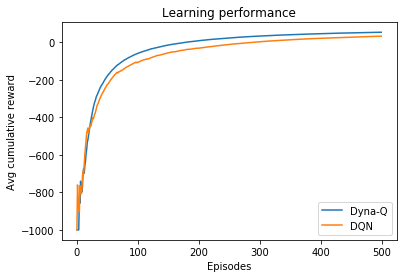

In [18]:
plt.plot(cum_avg_reward_lst)
plt.plot(cum_avg_reward_lst_dqn)
plt.gca().legend(('Dyna-Q','DQN'))
plt.ylabel('Avg cumulative reward')
plt.xlabel('Episodes')
plt.title('Learning performance')

plt.show()